# LeNet-5 CIFAR10 Classifier

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to the CIFAR10 object classification dataset. The basic architecture is shown in the figure below:

![](./images/lenet/lenet-5_1.jpg)



LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only 7 layers. 3 out of these 7 layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer. The additional details are summarized below:

- All convolutional layers use 5x5 kernels with stride 1.
- The two average pooling (subsampling) layers are 2x2 pixels wide with stride 1.
- Throughrout the network, tanh sigmoid activation functions are used. (**In this notebook, we replace these with ReLU activations**)
- The output layer uses 10 custom Euclidean Radial Basis Function neurons for the output layer. (**In this notebook, we replace these with softmax activations**)

**Please note that the original architecture was applied to MNIST-like grayscale images (1 color channel). CIFAR10 has 3 color-channels. I found that using the regular architecture results in very poor performance on CIFAR10 (approx. 50% ACC). Hence, I am multiplying the number of kernels by a factor of 3 (according to the 3 color channels) in each layer, which improves is a little bit (approx. 60% Acc).**

### References

- [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.

In [2]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['/Users/ZRC/miniconda3/envs/tryit/lib/python36.zip',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/lib-dynload',
 '',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages/IPython/extensions',
 '/Users/ZRC/.ipython',
 '/Users/ZRC']

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [6]:
from coke.visualization.image import show_batch

## Model Settings

In [61]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 3
LEARNING_RATE = 0.001
RANDOM_SEED = 7

# Architecture
NUM_CLASSES = 10
GRAYSCALE = False

# other
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [62]:
data_transforms = {"train": transforms.Compose([
                            transforms.ToTensor()]),
                    "val": transforms.Compose([
                      transforms.ToTensor()])
                   }

In [63]:
train_dataset = datasets.CIFAR10(root = "data",
                                train = True,
                                transform = data_transforms["train"],
                                download=True)

test_dataset = datasets.CIFAR10(root = "data",
                                train = False,
                                transform = data_transforms["val"],
                                download=False)

train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

data_loader = {"train": train_dataloader, "val": test_dataloader}

Files already downloaded and verified


In [64]:
batch_samples,labels = next(iter(train_dataloader))
batch_samples.shape,labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [65]:
help(show_batch)

Help on function show_batch in module coke.visualization.image:

show_batch(x, y, shape=None)
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images



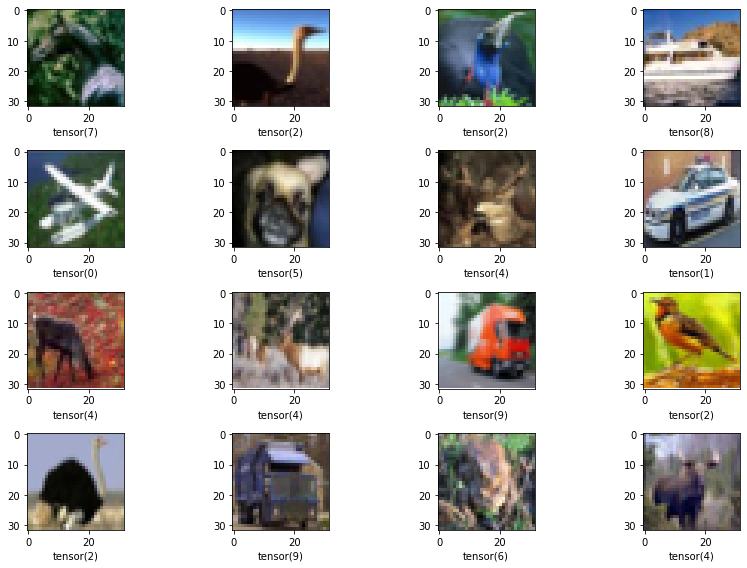

In [66]:
show_batch(batch_samples.permute(0,2,3,1), labels, (4,4))

## Model

In [79]:
class LNet5Zrc(torch.nn.Module):
    def __init__(self, num_classes, grascale = False):
        super(LNet5Zrc, self).__init__()
        
        if grascale:
            in_channels = 1
        else:
            in_channels = 3
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, in_channels*6, kernel_size=5),
            torch.nn.MaxPool2d(kernel_size = 2),
            torch.nn.Conv2d(in_channels*6,16*in_channels, kernel_size=5),
            torch.nn.MaxPool2d(kernel_size = 2),
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*in_channels*5*5, 120*in_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Linear(120*in_channels, 84*in_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Linear(84*in_channels, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim = 1, end_dim = -1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        
        return logits,probas

In [80]:
def init_weights(layer):
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
#         torch.nn.init.normal_(layer.weight, 0.0, 0.1)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0) 
            
model = LNet5Zrc(num_classes = NUM_CLASSES)
model.apply(init_weights)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [81]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 28, 28]           1,368
         MaxPool2d-2           [-1, 18, 14, 14]               0
            Conv2d-3           [-1, 48, 10, 10]          21,648
         MaxPool2d-4             [-1, 48, 5, 5]               0
            Linear-5                  [-1, 360]         432,360
              ReLU-6                  [-1, 360]               0
            Linear-7                  [-1, 252]          90,972
              ReLU-8                  [-1, 252]               0
            Linear-9                   [-1, 10]           2,530
Total params: 548,878
Trainable params: 548,878
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 2.09
Estimated Total Size (MB): 2.30
-------------------------------------------

In [82]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [83]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))

        with torch.set_grad_enabled(False):
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, 
                  metric_func(model, data_loader["train"], device)))
            
            print('Epoch: {0:03d}/{1:03d} validation accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, 
                  metric_func(model, data_loader["val"], device)))

In [84]:
train_model(model, 
            data_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/003 | Batch 000/781 | Loss: 2.65
Epoch: 001/003 | Batch 050/781 | Loss: 1.80
Epoch: 001/003 | Batch 100/781 | Loss: 1.73
Epoch: 001/003 | Batch 150/781 | Loss: 1.67
Epoch: 001/003 | Batch 200/781 | Loss: 1.27
Epoch: 001/003 | Batch 250/781 | Loss: 1.52
Epoch: 001/003 | Batch 300/781 | Loss: 1.31
Epoch: 001/003 | Batch 350/781 | Loss: 1.37
Epoch: 001/003 | Batch 400/781 | Loss: 1.56
Epoch: 001/003 | Batch 450/781 | Loss: 1.29
Epoch: 001/003 | Batch 500/781 | Loss: 1.23
Epoch: 001/003 | Batch 550/781 | Loss: 1.15
Epoch: 001/003 | Batch 600/781 | Loss: 1.18
Epoch: 001/003 | Batch 650/781 | Loss: 1.20
Epoch: 001/003 | Batch 700/781 | Loss: 1.37
Epoch: 001/003 | Batch 750/781 | Loss: 1.17
Epoch: 001/003 training accuracy: 61.22
Epoch: 001/003 validation accuracy: 57.43
Epoch: 002/003 | Batch 000/781 | Loss: 1.08
Epoch: 002/003 | Batch 050/781 | Loss: 1.24
Epoch: 002/003 | Batch 100/781 | Loss: 1.05
Epoch: 002/003 | Batch 150/781 | Loss: 0.99
Epoch: 002/003 | Batch 200/781 | Loss: